In [1]:
import sys
import time
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json

sys.path.append('../lib')
import utils

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def build_X_matrix_BNT(BNT_matrix):
    """
    Builds the X matrix for the BNT transform, according to eq.
    :param BNT_matrix:
    :return:
    """
    X = {}
    delta_kron = np.eye(BNT_matrix.shape[0])
    X['L', 'L'] = np.einsum('ae, bf -> aebf', BNT_matrix, BNT_matrix)
    X['G', 'G'] = np.einsum('ae, bf -> aebf', delta_kron, delta_kron)
    X['G', 'L'] = np.einsum('ae, bf -> aebf', delta_kron, BNT_matrix)
    X['L', 'G'] = np.einsum('ae, bf -> aebf', BNT_matrix, delta_kron)
    return X


def cov_BNT_transform(cov_noBNT_6D, X_dict, probe_A, probe_B, probe_C, probe_D, optimize=True):
    """same as above, but only for one probe (i.e., LL or GL: GG is not modified by the BNT)"""
    # todo it's nicer if you sandwitch the covariance, maybe? That is, X cov X instead of X X cov
    cov_BNT_6D = np.einsum('aebf, cgdh, LMefgh -> LMabcd', X_dict[probe_A, probe_B], X_dict[probe_C, probe_D],
                           cov_noBNT_6D, optimize=optimize)
    return cov_BNT_6D


def cov_3x2pt_BNT_transform(cov_3x2pt_10D_dict, X_dict, optimize=True):
    """in np.einsum below, L and M are the ell1, ell2 indices, which are not touched by the BNT transform"""

    cov_3x2pt_BNT_dict_10D = {}

    for probe_A, probe_B, probe_C, probe_D in cov_3x2pt_10D_dict.keys():
        cov_3x2pt_BNT_dict_10D[probe_A, probe_B, probe_C, probe_D] = \
            cov_BNT_transform(cov_3x2pt_10D_dict[probe_A, probe_B, probe_C, probe_D], X_dict,
                              probe_A, probe_B, probe_C, probe_D, optimize=optimize)

    return cov_3x2pt_BNT_dict_10D


def cl_BNT_transform(cl_3D, BNT_matrix, probe_A, probe_B):
    assert cl_3D.ndim == 3, 'cl_3D must be 3D'
    assert BNT_matrix.ndim == 2, 'BNT_matrix must be 2D'
    assert cl_3D.shape[1] == BNT_matrix.shape[0], 'the number of ell bins in cl_3D and BNT_matrix must be the same'

    BNT_transform_dict = {
        'L': BNT_matrix,
        'G': np.eye(BNT_matrix.shape[0]),
    }

    cl_3D_BNT = np.zeros(cl_3D.shape)
    for ell_idx in range(cl_3D.shape[0]):
        cl_3D_BNT[ell_idx, :, :] = BNT_transform_dict[probe_A] @ \
                                   cl_3D[ell_idx, :, :] @ \
                                   BNT_transform_dict[probe_B].T

    return cl_3D_BNT


def cl_BNT_transform_3x2pt(cl_3x2pt_5D, BNT_matrix):
    """wrapper function to quickly implement the cl (or derivatives) BNT transform for the 3x2pt datavector"""

    cl_3x2pt_5D_BNT = np.zeros(cl_3x2pt_5D.shape)
    cl_3x2pt_5D_BNT[0, 0, :, :, :] = cl_BNT_transform(cl_3x2pt_5D[0, 0, :, :, :], BNT_matrix, 'L', 'L')
    cl_3x2pt_5D_BNT[0, 1, :, :, :] = cl_BNT_transform(cl_3x2pt_5D[0, 1, :, :, :], BNT_matrix, 'L', 'G')
    cl_3x2pt_5D_BNT[1, 0, :, :, :] = cl_BNT_transform(cl_3x2pt_5D[1, 0, :, :, :], BNT_matrix, 'G', 'L')
    cl_3x2pt_5D_BNT[1, 1, :, :, :] = cl_3x2pt_5D[1, 1, :, :, :]  # no need to transform the GG part

    return cl_3x2pt_5D_BNT


def cl_1d_to_3x2pt_5d(cl_LL_1d, cl_GL_1d, cl_GG_1d, nbl, zbins):
    
    zpairs_auto, zpairs_cross, _ = utils.get_zpairs(zbins)
    
    # reshape to 2D
    cl_LL_2d = cl_LL_1d.reshape((nbl, zpairs_auto))
    cl_GL_2d = cl_GL_1d.reshape((nbl, zpairs_cross))
    cl_GG_2d = cl_GG_1d.reshape((nbl, zpairs_auto))

    # reshape to 3d
    cl_LL_3d = utils.cl_2D_to_3D_symmetric(cl_LL_2d, nbl, zpairs_auto, zbins)
    cl_GL_3d = utils.cl_2D_to_3D_asymmetric(cl_GL_2d, nbl, zbins, 'C')
    cl_GG_3d = utils.cl_2D_to_3D_symmetric(cl_GG_2d, nbl, zpairs_auto, zbins)

    # construct 3x2pt 5d vector
    cl_3x2pt_5d = np.zeros((2, 2, nbl, zbins, zbins))
    cl_3x2pt_5d[0, 0, ...] = cl_LL_3d
    cl_3x2pt_5d[1, 0, ...] = cl_GL_3d
    cl_3x2pt_5d[0, 1, ...] = cl_GL_3d.transpose(0, 2, 1)
    cl_3x2pt_5d[1, 1, ...] = cl_GG_3d
    
    return cl_3x2pt_5d


def compute_ells(nbl: int, ell_min: int, ell_max: int, recipe, output_ell_bin_edges: bool = False):
    """Compute the ell values and the bin widths for a given recipe.

    Parameters
    ----------
    nbl : int
        Number of ell bins.
    ell_min : int
        Minimum ell value.
    ell_max : int
        Maximum ell value.
    recipe : str
        Recipe to use. Must be either "ISTF" or "ISTNL".
    output_ell_bin_edges : bool, optional
        If True, also return the ell bin edges, by default False

    Returns
    -------
    ells : np.ndarray
        Central ell values.
    deltas : np.ndarray
        Bin widths
    ell_bin_edges : np.ndarray, optional
        ell bin edges. Returned only if output_ell_bin_edges is True.
    """
    if recipe == 'ISTF':
        ell_bin_edges = np.logspace(np.log10(ell_min), np.log10(ell_max), nbl + 1)
        ells = (ell_bin_edges[1:] + ell_bin_edges[:-1]) / 2
        deltas = np.diff(ell_bin_edges)
    elif recipe == 'ISTNL':
        ell_bin_edges = np.linspace(np.log(ell_min), np.log(ell_max), nbl + 1)
        ells = (ell_bin_edges[:-1] + ell_bin_edges[1:]) / 2.
        ells = np.exp(ells)
        deltas = np.diff(np.exp(ell_bin_edges))
    else:
        raise ValueError('recipe must be either "ISTF" or "ISTNL"')

    if output_ell_bin_edges:
        return ells, deltas, ell_bin_edges

    return ells, deltas

In [4]:
# ! settings
survey_area = 14_700  # deg^2
deg2_in_sphere = 41252.96  # deg^2 in a spere
fsky = survey_area / deg2_in_sphere

zbins = 13

ell_min = 10
ell_max = 5000
nbl = 32

n_gal = np.genfromtxt('/Users/davide/Documents/Lavoro/Programmi/CLOE_validation/data/nuisance/nuiTabSPV3.dat')[:, 1]
sigma_eps = 0.26 * np.sqrt(2)

EP_or_ED = 'EP'
GL_or_LG = 'GL'
triu_tril = 'triu'
row_col_major = 'row-major'
probe_ordering = [['L', 'L'], [GL_or_LG[0], GL_or_LG[1]], ['G', 'G']]
block_index = 'ell'
n_probes = 2
input_folder = 'cl_LiFE'

In [5]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, zbins)]

In [6]:
ind = utils.build_full_ind(triu_tril, row_col_major, zbins)
zpairs_auto, zpairs_cross, zpairs_3x2pt = utils.get_zpairs(zbins)

In [7]:
ind_auto = ind[:zpairs_auto, :]
ind_cross = ind[zpairs_auto:zpairs_auto + zpairs_cross, :]

In [8]:
ell_values, delta_values = compute_ells(nbl, ell_min, ell_max, recipe='ISTF', output_ell_bin_edges = False)
print(ell_values, delta_values)

[  11.07173512   13.44492858   16.32680901   19.82641192   24.0761443
   29.23679417   35.50361397   43.11370795   52.35500292   63.57714196
   77.2047131    93.75331355  113.84905725  138.2522638   167.88622503
  203.87213764  247.57152351  300.63774267  365.07854795  443.33204803
  538.35895294  653.75459205  793.88494293  964.05181742 1170.69345495
 1421.6281124  1726.34986676 2096.38782216 2545.74231185 3091.4145989
 3754.05011646 4558.71958485] [  2.14347023   2.6029167    3.16084415   3.83836168   4.66110308
   5.66019665   6.87344296   8.346745    10.13584494  12.30843314
  14.94670914  18.15049176  22.04099564  26.76541745  32.50250501
  39.46932022  47.92945152  58.20298679  70.67862377  85.8283764
 104.22543341 126.56584483 153.69485694 186.63889204 226.64438301
 275.22493189 334.21857683 405.85733396 492.85164544 598.49292865
 726.77810647 882.56083031]


In [9]:
# import and split the 1d vector
cl_3x2pt_1d = np.genfromtxt(f'../input/cl_LiFE/dv-3x2pt-LiFE-C13.dat')
elements_auto = nbl*zpairs_auto
elements_cross = nbl*zpairs_cross

# reshape
cl_3x2pt_2d = cl_3x2pt_1d.reshape((nbl, zpairs_3x2pt))

# split into 3 2d datavectors
cl_ll_3x2pt_2d = cl_3x2pt_2d[:, :zpairs_auto]
cl_gl_3x2pt_2d = cl_3x2pt_2d[:, zpairs_auto:zpairs_auto + zpairs_cross]
cl_gg_3x2pt_2d = cl_3x2pt_2d[:, zpairs_auto + zpairs_cross:]

cl_ll_3x2pt_3d = utils.cl_2D_to_3D_symmetric(cl_ll_3x2pt_2d, nbl=nbl, zpairs=zpairs_auto, zbins=zbins)
cl_gl_3x2pt_3d = utils.cl_2D_to_3D_asymmetric(cl_gl_3x2pt_2d, nbl=nbl, zbins=zbins, order='C')
cl_gg_3x2pt_3d = utils.cl_2D_to_3D_symmetric(cl_gg_3x2pt_2d, nbl=nbl, zpairs=zpairs_auto, zbins=zbins)

cl_3x2pt_5D = np.zeros((n_probes, n_probes, nbl, zbins, zbins))
cl_3x2pt_5D[0, 0, :, :, :] = cl_ll_3x2pt_3d
cl_3x2pt_5D[1, 1, :, :, :] = cl_gg_3x2pt_3d
cl_3x2pt_5D[1, 0, :, :, :] = cl_gl_3x2pt_3d
cl_3x2pt_5D[0, 1, :, :, :] = np.transpose(cl_gl_3x2pt_3d, (0, 2, 1))


In [10]:
# cl_LL_3D_old = np.load(f'../input/march_2023/Cl_LL.npy')
# cl_GL_3D_old = np.load(f'../input/march_2023/Cl_GL.npy')
# cl_GG_3D_old = np.load(f'../input/march_2023/Cl_GG.npy')

# ell_values_old = np.load(f'../input/ell_values.npy')
# delta_ell_old = np.load(f'../input/delta_ells.npy')

## Compute covariance 

In [11]:
# create a noise with dummy axis for ell, to have the same shape as cl_3x2pt_5D
noise_3x2pt_4D = utils.build_noise(zbins, n_probes, sigma_eps2=sigma_eps ** 2, ng=n_gal, EP_or_ED=EP_or_ED)
noise_3x2pt_5D = np.zeros((n_probes, n_probes, nbl, zbins, zbins))
for probe_A in (0, 1):
    for probe_B in (0, 1):
        for ell_idx in range(nbl):
            noise_3x2pt_5D[probe_A, probe_B, ell_idx, :, :] = noise_3x2pt_4D[probe_A, probe_B, ...]

# 5d versions of auto.probe data and spectra
# cl_LL_5D = cl_LL_3D[np.newaxis, np.newaxis, ...]
# noise_LL_5D = noise_3x2pt_5D[0, 0, ...][np.newaxis, np.newaxis, ...]

### Regular (no BNT) covariance

In [12]:
# compute
# cov_WL_6D = utils.covariance_einsum(cl_LL_5D, noise_LL_5D, fsky, ell_values, delta_ell)[0, 0, 0, 0, ...]
cov_3x2pt_10D_arr = utils.covariance_einsum(cl_3x2pt_5D, noise_3x2pt_5D, fsky, ell_values, delta_values)

# reshape to 4D
# cov_WL_4D = utils.cov_6D_to_4D(cov_WL_6D, nbl, zpairs_auto, ind[:zpairs_auto])
cov_3x2pt_10D_dict = utils.cov_10D_array_to_dict(cov_3x2pt_10D_arr)  # not important, equivalent to the array above
cov_3x2pt_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_10D_dict, probe_ordering, nbl, zbins, ind.copy(), GL_or_LG)

# reshape to 2D
# cov_WL_2D = utils.cov_4D_to_2D(cov_WL_4D, block_index=block_index)
cov_3x2pt_2D = utils.cov_4D_to_2D(cov_3x2pt_4D, block_index=block_index)
cov_3x2pt_2DCLOE = utils.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_4D, nbl, zbins, block_index)

the probe ordering (LL, LG/GL, GG) is hardcoded, this function won't work with other combinations (but it will work both for LG and GL) 


/var/folders/l4/w0t4jccj3ys27bbg1y8nwdk00000gn/T/ipykernel_36438/540200563.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(cov_3x2pt_2D))
/var/folders/l4/w0t4jccj3ys27bbg1y8nwdk00000gn/T/ipykernel_36438/540200563.py:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(cov_3x2pt_2D))
/var/folders/l4/w0t4jccj3ys27bbg1y8nwdk00000gn/T/ipykernel_36438/540200563.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(cov_3x2pt_2DCLOE))
/var/folders/l4/w0t4jccj3ys27bbg1y8nwdk00000gn/T/ipykernel_36438/540200563.py:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(cov_3x2pt_2DCLOE))


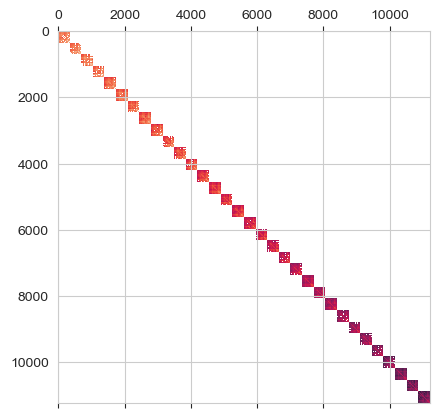

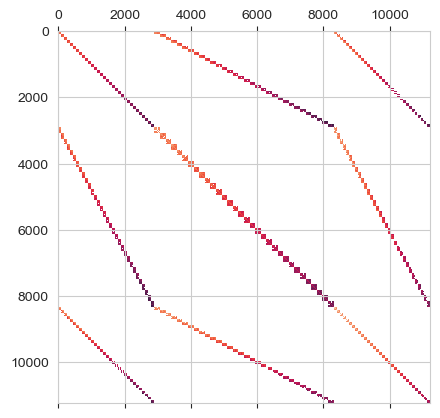

In [17]:
plt.matshow(np.log10(cov_3x2pt_2D))
plt.matshow(np.log10(cov_3x2pt_2DCLOE))

In [14]:
other_quantities_tosave = {
    'n_gal': list(n_gal),
    'survey_area': survey_area,
    'sigma_eps': sigma_eps,
}

In [15]:
np.save(f'../output/cl_LiFE/CovMat-3x2pt-Gauss-{nbl}Bins_2DCLOE.npy', cov_3x2pt_2DCLOE)
np.save(f'../output/cl_LiFE/CovMat-3x2pt-Gauss-{nbl}Bins.npy', cov_3x2pt_2D)
np.savetxt(f'../output/cl_LiFE/ell_values.txt', ell_values)
np.savetxt(f'../output/cl_LiFE/delta_values.txt', delta_values)
with open('../output/cl_LiFE/other_specs.txt', 'w') as file:
     file.write(json.dumps(other_quantities_tosave))

In [16]:
assert False, 'stop here'

AssertionError: stop here

### BNT covariance

In [ ]:
# transform (I need the 3x2pt dictionary for the BNT covariance)
X_dict = build_X_matrix_BNT(BNT_matrix)
cov_WL_BNTcov_6D = cov_BNT_transform(cov_WL_6D, X_dict, 'L', 'L', 'L', 'L')
cov_3x2pt_BNTcov_10D_dict = cov_3x2pt_BNT_transform(cov_3x2pt_10D_dict, X_dict)

# reshape to 4D
cov_WL_BNTcov_4D = utils.cov_6D_to_4D(cov_WL_BNTcov_6D, nbl, zpairs_auto, ind[:zpairs_auto])
cov_3x2pt_BNTcov_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_BNTcov_10D_dict, probe_ordering, nbl, zbins, ind.copy(),
                                                  GL_or_LG)
# reshape to 2D
cov_WL_BNTcov_2D = utils.cov_4D_to_2D(cov_WL_BNTcov_4D, block_index=block_index)
cov_3x2pt_BNTcov_2D = utils.cov_4D_to_2D(cov_3x2pt_BNTcov_4D, block_index=block_index)
cov_3x2pt_BNTcov_2DCLOE = utils.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_BNTcov_4D, nbl, zbins)

#### Covariance matrix with and without BNT (just for visual comparison)

In [ ]:
utils.compare_arrays(cov_3x2pt_2DCLOE, cov_3x2pt_BNTcov_2DCLOE, 'cov_3x2pt_2DCLOE', 'cov_3x2pt_BNTcov_2DCLOE',
                     plot_array=True, log_array=True)

### BNT covariance with BNT cls

In [ ]:
# transform cls AND NOISE
cl_LL_BNT_3D = cl_BNT_transform(cl_LL_3D, BNT_matrix, 'L', 'L')
noise_LL_BNT_3D = cl_BNT_transform(noise_LL_5D[0, 0, ...], BNT_matrix, 'L', 'L')
cl_3x2pt_BNT_5D = cl_BNT_transform_3x2pt(cl_3x2pt_5D, BNT_matrix)
noise_3x2pt_BNT_5D = cl_BNT_transform_3x2pt(noise_3x2pt_5D, BNT_matrix)

# compute cov
cl_LL_BNT_5D = cl_LL_BNT_3D[np.newaxis, np.newaxis, ...]
noise_LL_BNT_5D = noise_LL_BNT_3D[np.newaxis, np.newaxis, ...]
cov_WL_BNTcl_6D = utils.covariance_einsum(cl_LL_BNT_5D, noise_LL_BNT_5D, fsky, ell_values, delta_ell)[0, 0, 0, 0, ...]
cov_3x2pt_BNTcl_10D_arr = utils.covariance_einsum(cl_3x2pt_BNT_5D, noise_3x2pt_BNT_5D, fsky, ell_values, delta_ell)

In [ ]:
# reshape to 4D
cov_WL_BNTcl_4D = utils.cov_6D_to_4D(cov_WL_BNTcl_6D, nbl, zpairs_auto, ind[:zpairs_auto])
cov_3x2pt_BNTcl_10D_dict = utils.cov_10D_array_to_dict(cov_3x2pt_BNTcl_10D_arr)  # not important, equivalent to the array above
cov_3x2pt_BNTcl_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_BNTcl_10D_dict, probe_ordering, nbl, zbins, ind.copy(), GL_or_LG)

# reshape to 2D
cov_WL_BNTcl_2D = utils.cov_4D_to_2D(cov_WL_BNTcl_4D, block_index=block_index)
cov_3x2pt_BNTcl_2D = utils.cov_4D_to_2D(cov_3x2pt_BNTcl_4D, block_index=block_index)
cov_3x2pt_BNTcl_2DCLOE = utils.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_BNTcl_4D, nbl, zbins)

## BNT cov vs. cov with BNT cls

In [ ]:
# utils.compare_arrays(cov_3x2pt_BNTcov_2DCLOE, cov_3x2pt_BNTcl_2DCLOE, 'cov_3x2pt_BNTcov_2DCLOE', 'cov_3x2pt_BNTcl_2DCLOE',
#                   plot_array=True, log_array=True,
#                   plot_diff=False, log_diff=False, plot_diff_threshold=5)ù
rtol = 0.05
assert np.allclose(cov_3x2pt_BNTcov_2DCLOE, cov_3x2pt_BNTcl_2DCLOE, rtol=rtol, atol=0)
print(f'equal to within {rtol*100}% tolerance')

In [ ]:
np.savez_compressed('../output/cov_3x2pt_2D.npz', cov_3x2pt_2D)
np.savez_compressed('../output/cov_3x2pt_BNTcov_2D.npz', cov_3x2pt_BNTcov_2D)

# format used by CLOE 
np.savez_compressed('../output/cov_3x2pt_2DCLOE.npz', cov_3x2pt_2DCLOE)
np.savez_compressed('../output/cov_3x2pt_BNTcov_2DCLOE.npz', cov_3x2pt_BNTcov_2DCLOE)

# Test $\chi^2$ with and without BNT

In [ ]:
BNT_transform_davide = True

In [ ]:
# import the data and theory vectors - here, "data" is from the benchmark datavector, which could be outdated
# cl_LL_theory_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_LL_nsfid.npy')
# cl_GL_theory_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_GL_nsfid.npy')
# cl_GG_theory_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_GG_nsfid.npy')

# cl_LL_data_3D = np.load('../input/test_chi2/from_photo_class/cloedata_Cl_3d_LL_nsfid.npy') 
# cl_GL_data_3D = np.load('../input/test_chi2/from_photo_class/cloedata_Cl_3d_GL_nsfid.npy')
# cl_GG_data_3D = np.load('../input/test_chi2/from_photo_class/cloedata_Cl_3d_GG_nsfid.npy')

In [ ]:
# import the data and theory vectors - here, "data" is from the Photo class, with ns = 0.9 instead of 0.96
cl_LL_theory_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_LL_nsfid.npy')
cl_GL_theory_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_GL_nsfid.npy')
cl_GG_theory_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_GG_nsfid.npy')

cl_LL_data_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_LL_nsmod.npy') 
cl_GL_data_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_GL_nsmod.npy')
cl_GG_data_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_GG_nsmod.npy')

In [ ]:
# same thing, but BNT-transformed in the Photo class (should be the cleaner way)
cl_LL_theory_BNT_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_LL_nsfid_BNT.npy')
cl_GL_theory_BNT_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_GL_nsfid_BNT.npy')
cl_GG_theory_BNT_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_GG_nsfid_BNT.npy')

cl_LL_data_BNT_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_LL_nsmod_BNT.npy') 
cl_GL_data_BNT_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_GL_nsmod_BNT.npy')
cl_GG_data_BNT_3D = np.load('../input/test_chi2/from_photo_class/cloetheory_Cl_3d_GG_nsmod_BNT.npy')

In [ ]:
print('is theory == theory_BNT?', np.all(cl_LL_theory_3D == cl_LL_theory_BNT_3D))
print('is data == data_BNT?', np.all(cl_LL_data_3D == cl_LL_data_BNT_3D))

assert not np.all(cl_LL_theory_3D == cl_LL_theory_BNT_3D), 'cl_LL theory should not be equal to its BNT-transfor,'
assert not np.all(cl_LL_data_3D == cl_LL_data_BNT_3D), 'cl_LL data should not be equal to its BNT-transfor,'

### Check $C(\ell)$

In [ ]:
for zi in range(zbins):
    plt.loglog(ell_values, cl_LL_data_BNT_3D[:, zi, zi])
    plt.loglog(ell_values, cl_LL_data_3D[:, zi, zi],  ls='--')
plt.legend(['cl_LL_data_BNT_3D', 'cl_LL_data_3D'])

In [ ]:
# create 3x2pt data vectors
cl_3x2pt_theory_5D = np.zeros((n_probes, n_probes, nbl, zbins, zbins))
cl_3x2pt_theory_5D[0, 0, :, :, :] = cl_LL_theory_3D
cl_3x2pt_theory_5D[0, 1, :, :, :] = cl_GL_theory_3D.transpose(0, 2, 1)
cl_3x2pt_theory_5D[1, 0, :, :, :] = cl_GL_theory_3D
cl_3x2pt_theory_5D[1, 1, :, :, :] = cl_GG_theory_3D

cl_3x2pt_data_5D = np.zeros((n_probes, n_probes, nbl, zbins, zbins))
cl_3x2pt_data_5D[0, 0, :, :, :] = cl_LL_data_3D
cl_3x2pt_data_5D[0, 1, :, :, :] = cl_GL_data_3D.transpose(0, 2, 1)
cl_3x2pt_data_5D[1, 0, :, :, :] = cl_GL_data_3D
cl_3x2pt_data_5D[1, 1, :, :, :] = cl_GG_data_3D

In [ ]:
# # BNT transform data and theory vectors
# if BNT_transform_davide:
#     cl_3x2pt_theory_BNT_5D = cl_BNT_transform_3x2pt(cl_3x2pt_theory_5D, BNT_matrix)
#     cl_3x2pt_data_BNT_5D = cl_BNT_transform_3x2pt(cl_3x2pt_data_5D, BNT_matrix)    
# else:
#     # BNT-transformed by CLOE
#     cl_3x2pt_theory_BNT_5D = np.zeros((n_probes, n_probes, nbl, zbins, zbins))
#     cl_3x2pt_theory_BNT_5D[0, 0, :, :, :] = cl_LL_theory_BNT_3D
#     cl_3x2pt_theory_BNT_5D[0, 1, :, :, :] = cl_GL_theory_BNT_3D.transpose(0, 2, 1)
#     cl_3x2pt_theory_BNT_5D[1, 0, :, :, :] = cl_GL_theory_BNT_3D
#     cl_3x2pt_theory_BNT_5D[1, 1, :, :, :] = cl_GG_theory_BNT_3D

#     cl_3x2pt_data_BNT_5D = np.zeros((n_probes, n_probes, nbl, zbins, zbins))
#     cl_3x2pt_data_BNT_5D[0, 0, :, :, :] = cl_LL_data_BNT_3D
#     cl_3x2pt_data_BNT_5D[0, 1, :, :, :] = cl_GL_data_BNT_3D.transpose(0, 2, 1)
#     cl_3x2pt_data_BNT_5D[1, 0, :, :, :] = cl_GL_data_BNT_3D
#     cl_3x2pt_data_BNT_5D[1, 1, :, :, :] = cl_GG_data_BNT_3D

In [ ]:
# BNT transform data and theory vectors

# davide
cl_3x2pt_theory_BNT_dav_5D = cl_BNT_transform_3x2pt(cl_3x2pt_theory_5D, BNT_matrix)
cl_3x2pt_data_BNT_dav_5D = cl_BNT_transform_3x2pt(cl_3x2pt_data_5D, BNT_matrix)    

# CLOE
cl_3x2pt_theory_BNT_cloe_5D = np.zeros((n_probes, n_probes, nbl, zbins, zbins))
cl_3x2pt_theory_BNT_cloe_5D[0, 0, :, :, :] = cl_LL_theory_BNT_3D
cl_3x2pt_theory_BNT_cloe_5D[0, 1, :, :, :] = cl_GL_theory_BNT_3D.transpose(0, 2, 1)
cl_3x2pt_theory_BNT_cloe_5D[1, 0, :, :, :] = cl_GL_theory_BNT_3D
cl_3x2pt_theory_BNT_cloe_5D[1, 1, :, :, :] = cl_GG_theory_BNT_3D

cl_3x2pt_data_BNT_cloe_5D = np.zeros((n_probes, n_probes, nbl, zbins, zbins))
cl_3x2pt_data_BNT_cloe_5D[0, 0, :, :, :] = cl_LL_data_BNT_3D
cl_3x2pt_data_BNT_cloe_5D[0, 1, :, :, :] = cl_GL_data_BNT_3D.transpose(0, 2, 1)
cl_3x2pt_data_BNT_cloe_5D[1, 0, :, :, :] = cl_GL_data_BNT_3D
cl_3x2pt_data_BNT_cloe_5D[1, 1, :, :, :] = cl_GG_data_BNT_3D

In [ ]:
for zi in range(zbins):
    plt.loglog(ell_values, cl_3x2pt_theory_BNT_dav_5D[0, 0, :, zi, zi], c=colors[zi], ls='-')
    plt.loglog(ell_values, cl_3x2pt_theory_BNT_cloe_5D[0, 0, :, zi, zi], ls='--', c=colors[zi]) 
plt.legend(['cl_3x2pt_theory_BNT_dav_5D', 'cl_3x2pt_theory_BNT_cloe_5D'])
plt.title('CLOE vs davide cl BNT transform')

In [ ]:
# better comparison of the BNT cls
probe_A = 0
probe_B = 0
ell_idx = 0
diff = utils.percent_diff(cl_3x2pt_theory_BNT_dav_5D, cl_3x2pt_theory_BNT_cloe_5D)

fig, ax = plt.subplots()
plt.title('BNT cls transformed by Davide vs CLOE, % diff')
im = ax.matshow(diff[probe_A, probe_B, ell_idx, :, :])
plt.colorbar(im)
    
# Iterate over each cell in the plot and display its value
for i in range(diff.shape[3]):
    for j in range(diff.shape[4]):
        ax.annotate(f'{int(diff[probe_A, probe_B, ell_idx, i, j])}', xy=(j, i),
                    horizontalalignment='center',
                    verticalalignment='center')
plt.show()

In [ ]:
if BNT_transform_davide:
    cl_3x2pt_theory_BNT_5D = cl_3x2pt_theory_BNT_dav_5D
    cl_3x2pt_data_BNT_5D = cl_3x2pt_data_BNT_dav_5D
else:
    cl_3x2pt_theory_BNT_5D = cl_3x2pt_theory_BNT_cloe_5D
    cl_3x2pt_data_BNT_5D = cl_3x2pt_data_BNT_cloe_5D
    

In [ ]:
# compute data covariance (used to compute chi2) and theory covariance (in general I need the data covariance, but it it just the covariance 
# with the fiducial theory! that0s the covariance file we need in the repository)
cov_3x2pt_10D_arr = utils.covariance_einsum(cl_3x2pt_data_5D, noise_3x2pt_5D, fsky, ell_values, delta_ell)

# convenience variables, for better readability
cl_LL_data_5D = cl_3x2pt_data_5D[0, 0, :, :, :][None, None, ...]
noise_LL_5D = noise_3x2pt_5D[0, 0, :, :, :][None, None, ...]
cov_WL_6D = utils.covariance_einsum(cl_LL_data_5D, noise_LL_5D, fsky, ell_values, delta_ell)[0, 0, 0, 0, ...]

# BNT transform covariance
X_dict = build_X_matrix_BNT(BNT_matrix)
cov_3x2pt_10D_dict = utils.cov_10D_array_to_dict(cov_3x2pt_10D_arr)  # not important, equivalent to the array above
cov_3x2pt_BNT_10D_dict = cov_3x2pt_BNT_transform(cov_3x2pt_10D_dict, X_dict)
cov_WL_BNT_6D = cov_BNT_transform(cov_WL_6D, X_dict, 'L', 'L', 'L', 'L')

# reshape to 4D
cov_3x2pt_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_10D_dict, probe_ordering, nbl, zbins, ind.copy(), GL_or_LG)
cov_3x2pt_BNT_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_BNT_10D_dict, probe_ordering, nbl, zbins, ind.copy(), GL_or_LG)
cov_WL_4D = utils.cov_6D_to_4D(cov_WL_6D, nbl, zpairs_auto, ind_auto)
cov_WL_BNT_4D = utils.cov_6D_to_4D(cov_WL_BNT_6D, nbl, zpairs_auto, ind_auto)

# reshape to 2D
cov_3x2pt_2DCLOE = utils.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_4D, nbl, zbins)
cov_3x2pt_BNT_2DCLOE = utils.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_BNT_4D, nbl, zbins)
cov_WL_2D = utils.cov_4D_to_2D(cov_WL_4D, block_index=block_index)
cov_WL_BNT_2D = utils.cov_4D_to_2D(cov_WL_BNT_4D, block_index=block_index)

In [ ]:
# utils.compare_arrays(cov_3x2pt_2DCLOE, cov_3x2pt_BNT_2DCLOE, 
#                      'cov_3x2pt_2DCLOE', 'cov_3x2pt_BNT_2DCLOE',
#                     plot_array=True, log_array=True,
#                   plot_diff=False, log_diff=False, plot_diff_threshold=5)

In [ ]:
# flatten the 3x2pt theory and data vectors (flatten first, then concatenate the probes in this covariance ordering)
cl_LL_theory_1D = utils.cl_3D_to_1D(cl_3x2pt_theory_5D[0, 0, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell', use_triu_row_major=True)
cl_GL_theory_1D = utils.cl_3D_to_1D(cl_3x2pt_theory_5D[1, 0, :, :, :], ind_cross, is_auto_spectrum=False, block_index='ell', use_triu_row_major=True)
cl_GG_theory_1D = utils.cl_3D_to_1D(cl_3x2pt_theory_5D[1, 1, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell', use_triu_row_major=True)

cl_LL_data_1D = utils.cl_3D_to_1D(cl_3x2pt_data_5D[0, 0, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell', use_triu_row_major=True)
cl_GL_data_1D = utils.cl_3D_to_1D(cl_3x2pt_data_5D[1, 0, :, :, :], ind_cross, is_auto_spectrum=False, block_index='ell', use_triu_row_major=True)
cl_GG_data_1D = utils.cl_3D_to_1D(cl_3x2pt_data_5D[1, 1, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell', use_triu_row_major=True)

cl_LL_theory_BNT_1D = utils.cl_3D_to_1D(cl_3x2pt_theory_BNT_5D[0, 0, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell', use_triu_row_major=True)
cl_GL_theory_BNT_1D = utils.cl_3D_to_1D(cl_3x2pt_theory_BNT_5D[1, 0, :, :, :], ind_cross, is_auto_spectrum=False, block_index='ell', use_triu_row_major=True)
cl_GG_theory_BNT_1D = utils.cl_3D_to_1D(cl_3x2pt_theory_BNT_5D[1, 1, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell', use_triu_row_major=True)

cl_LL_data_BNT_1D = utils.cl_3D_to_1D(cl_3x2pt_data_BNT_5D[0, 0, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell', use_triu_row_major=True)
cl_GL_data_BNT_1D = utils.cl_3D_to_1D(cl_3x2pt_data_BNT_5D[1, 0, :, :, :], ind_cross, is_auto_spectrum=False, block_index='ell', use_triu_row_major=True)
cl_GG_data_BNT_1D = utils.cl_3D_to_1D(cl_3x2pt_data_BNT_5D[1, 1, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell', use_triu_row_major=True)

In [ ]:
# # flatten the 3x2pt theory and data vectors (flatten first, then concatenate the probes in this covariance ordering)
# # ! TODO debug the function cl_3D_to_2D_or_1D
# cl_LL_theory_1D = utils.cl_3D_to_2D_or_1D(cl_3x2pt_theory_5D[0, 0, :, :, :], ind, is_auto_spectrum=True, use_triu_row_major=True, convert_to_2D=False, block_index='ell')
# cl_GL_theory_1D = utils.cl_3D_to_2D_or_1D(cl_3x2pt_theory_5D[1, 0, :, :, :], ind, is_auto_spectrum=False, use_triu_row_major=True, convert_to_2D=False, block_index='ell')
# cl_GG_theory_1D = utils.cl_3D_to_2D_or_1D(cl_3x2pt_theory_5D[1, 1, :, :, :], ind, is_auto_spectrum=True, use_triu_row_major=True, convert_to_2D=False, block_index='ell')

# cl_LL_data_1D = utils.cl_3D_to_2D_or_1D(cl_3x2pt_data_5D[0, 0, :, :, :], ind, is_auto_spectrum=True, use_triu_row_major=True, convert_to_2D=False, block_index='ell')
# cl_GL_data_1D = utils.cl_3D_to_2D_or_1D(cl_3x2pt_data_5D[1, 0, :, :, :], ind, is_auto_spectrum=False, use_triu_row_major=True, convert_to_2D=False, block_index='ell')
# cl_GG_data_1D = utils.cl_3D_to_2D_or_1D(cl_3x2pt_data_5D[1, 1, :, :, :], ind, is_auto_spectrum=True, use_triu_row_major=True, convert_to_2D=False, block_index='ell')

# cl_LL_theory_BNT_1D = utils.cl_3D_to_2D_or_1D(cl_3x2pt_theory_BNT_5D[0, 0, :, :, :], ind, is_auto_spectrum=True, use_triu_row_major=True, convert_to_2D=False, block_index='ell')
# cl_GL_theory_BNT_1D = utils.cl_3D_to_2D_or_1D(cl_3x2pt_theory_BNT_5D[1, 0, :, :, :], ind, is_auto_spectrum=False, use_triu_row_major=True, convert_to_2D=False, block_index='ell')
# cl_GG_theory_BNT_1D = utils.cl_3D_to_2D_or_1D(cl_3x2pt_theory_BNT_5D[1, 1, :, :, :], ind, is_auto_spectrum=True, use_triu_row_major=True, convert_to_2D=False, block_index='ell')

# cl_LL_data_BNT_1D = utils.cl_3D_to_2D_or_1D(cl_3x2pt_data_BNT_5D[0, 0, :, :, :], ind, is_auto_spectrum=True, use_triu_row_major=True, convert_to_2D=False, block_index='ell')
# cl_GL_data_BNT_1D = utils.cl_3D_to_2D_or_1D(cl_3x2pt_data_BNT_5D[1, 0, :, :, :], ind, is_auto_spectrum=False, use_triu_row_major=True, convert_to_2D=False, block_index='ell')
# cl_GG_data_BNT_1D = utils.cl_3D_to_2D_or_1D(cl_3x2pt_data_BNT_5D[1, 1, :, :, :], ind, is_auto_spectrum=True, use_triu_row_major=True, convert_to_2D=False, block_index='ell')

In [ ]:
# concatenate
cl_3x2pt_theory_1D = np.concatenate((cl_LL_theory_1D, cl_GL_theory_1D, cl_GG_theory_1D))
cl_3x2pt_data_1D = np.concatenate((cl_LL_data_1D, cl_GL_data_1D, cl_GG_data_1D))

cl_3x2pt_theory_BNT_1D = np.concatenate((cl_LL_theory_BNT_1D, cl_GL_theory_BNT_1D, cl_GG_theory_BNT_1D))
cl_3x2pt_data_BNT_1D = np.concatenate((cl_LL_data_BNT_1D, cl_GL_data_BNT_1D, cl_GG_data_BNT_1D))

### Perform some tests on the flattened theory (/data) vector from Euclike, with/without BNT

In [ ]:
# import theory vector outputted directly from euclike.py (already flattened)
cl_3x2pt_theory_BNT_euclike_1D = np.load('../input/test_chi2/from_euclike/photo_theory_vec_BNT_nsfid.npy')
cl_3x2pt_data_BNT_euclike_1D = np.load('../input/test_chi2/from_euclike/photo_theory_vec_BNT_nsmod.npy')
cl_3x2pt_theory_euclike_1D = np.load('../input/test_chi2/from_euclike/photo_theory_vec_nsfid.npy')
cl_3x2pt_data_euclike_1D = np.load('../input/test_chi2/from_euclike/photo_theory_vec_nsmod.npy')

In [ ]:
print(np.allclose(cl_3x2pt_theory_1D, cl_3x2pt_theory_euclike_1D, rtol=1e-8, atol=0))
plt.plot(cl_3x2pt_theory_1D, label='cl_3x2pt_theory_1D')
plt.plot(cl_3x2pt_theory_euclike_1D, label='cl_3x2pt_theory_euclike_1D', ls='--')
plt.yscale('log')
plt.legend()

In [ ]:
print(np.allclose(cl_3x2pt_theory_BNT_euclike_1D[:1100], cl_3x2pt_theory_BNT_1D[:1100], rtol=1e-8, atol=0))
plt.plot(cl_3x2pt_theory_BNT_1D, label='cl_3x2pt_theory_BNT_1D')
plt.plot(cl_3x2pt_theory_BNT_euclike_1D, label='cl_3x2pt_theory_BNT_euclike_1D', ls='--')
# plt.xlim(0, 1300)
plt.yscale('log')
plt.legend()

### BNT transform the covariance and compute $\chi^2$

In [ ]:
# BNT transform covariance
X_dict = build_X_matrix_BNT(BNT_matrix)
cov_WL_BNT_6D = cov_BNT_transform(cov_WL_6D, X_dict, 'L', 'L', 'L', 'L')
cov_3x2pt_BNT_10D_dict = cov_3x2pt_BNT_transform(cov_3x2pt_10D_dict, X_dict)

# reshape to 4D
cov_WL_BNT_4D = utils.cov_6D_to_4D(cov_WL_BNT_6D, nbl, zpairs_auto, ind[:zpairs_auto])
cov_3x2pt_BNT_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_BNT_10D_dict, probe_ordering, nbl, zbins, ind.copy(), GL_or_LG)

# reshape to 2D
cov_WL_BNT_2D = utils.cov_4D_to_2D(cov_WL_BNT_4D, block_index=block_index)
cov_3x2pt_BNT_2DCLOE = utils.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_BNT_4D, nbl, zbins)

In [ ]:
# compute chi2
chi2_3x2pt_noBNT = (cl_3x2pt_data_1D - cl_3x2pt_theory_1D) @ np.linalg.inv(cov_3x2pt_2DCLOE) @ (cl_3x2pt_data_1D - cl_3x2pt_theory_1D)
chi2_3x2pt_BNT = (cl_3x2pt_data_BNT_1D - cl_3x2pt_theory_BNT_1D) @ np.linalg.inv(cov_3x2pt_BNT_2DCLOE) @ (cl_3x2pt_data_BNT_1D - cl_3x2pt_theory_BNT_1D)

chi2_LL_noBNT = (cl_LL_data_1D - cl_LL_theory_1D) @ np.linalg.inv(cov_WL_2D) @ (cl_LL_data_1D - cl_LL_theory_1D)
chi2_LL_BNT = (cl_LL_data_BNT_1D - cl_LL_theory_BNT_1D) @ np.linalg.inv(cov_WL_BNT_2D) @ (cl_LL_data_BNT_1D - cl_LL_theory_BNT_1D)

In [ ]:
print('chi squared 3x2pt, no BNT = ', chi2_3x2pt_noBNT)
print('chi squared 3x2pt, BNT = ', chi2_3x2pt_BNT)
print('chi squared LL, no BNT = ', chi2_LL_noBNT)
print('chi squared LL, BNT = ', chi2_LL_BNT)

### Compute and save covariance with fiducial cls from euclike

In [ ]:
# get photo data from Euclike and reshape it
cl_LL_euclike_1d = np.load(f'/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/photodata_LL.npy')
cl_GL_euclike_1d = np.load(f'/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/photodata_GL.npy')
cl_GG_euclike_1d = np.load(f'/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/photodata_GG.npy')

cl_LL_BNT_euclike_1d = np.load(f'/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/photodata_BNT_LL.npy')
cl_GL_BNT_euclike_1d = np.load(f'/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/photodata_BNT_GL.npy')
cl_GG_BNT_euclike_1d = np.load(f'/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/photodata_BNT_GG.npy')

cov_euclike_import = np.load(f'/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/cov_from_euclike.npy')
cov_BNT_euclike_import = np.load(f'/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/cov_BNT_from_euclike.npy')

In [ ]:
cl_3x2pt_euclike_1d = np.concatenate((cl_LL_euclike_1d, cl_GL_euclike_1d, cl_GG_euclike_1d))
cl_3x2pt_BNT_euclike_1d = np.concatenate((cl_LL_BNT_euclike_1d, cl_GL_BNT_euclike_1d, cl_GG_BNT_euclike_1d))

In [ ]:
# these are also from euclike, but newer. They are the same as the ones above
data_vector_phot =  np.load('/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/data_vector_phot.npy')
data_vector_phot_BNT =  np.load('/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/data_vector_phot_BNT.npy')

cov_matrix_phot =  np.load('/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/cov_matrix_phot.npy')
cov_matrix_phot_BNT =  np.load('/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/cov_matrix_phot_BNT.npy')

In [ ]:
assert np.array_equal(data_vector_phot, cl_3x2pt_euclike_1d), 'data vector not equal'
assert np.array_equal(data_vector_phot_BNT, cl_3x2pt_BNT_euclike_1d), 'data vector BNT not equal'

In [ ]:
# construct 3x2pt 5d datavector to construct the covariance
cl_3x2pt_euclike_5d = cl_1d_to_3x2pt_5d(cl_LL_euclike_1d, cl_GL_euclike_1d, cl_GG_euclike_1d)
cl_3x2pt_BNT_euclike_5d = cl_1d_to_3x2pt_5d(cl_LL_BNT_euclike_1d, cl_GL_BNT_euclike_1d, cl_GG_BNT_euclike_1d)

In [ ]:
# construct covariance
cov_3x2pt_10D_arr = utils.covariance_einsum(cl_3x2pt_theory_5D, noise_3x2pt_5D, fsky, ell_values, delta_ell)
cov_3x2pt_euclike_10D_arr = utils.covariance_einsum(cl_3x2pt_euclike_5d, noise_3x2pt_5D, fsky, ell_values, delta_ell)

In [ ]:
# BNT transform covariance
X_dict = build_X_matrix_BNT(BNT_matrix)

# cov_3x2pt_10D_dict = utils.cov_10D_array_to_dict(cov_3x2pt_10D_arr)  # not important, equivalent to the array above
cov_3x2pt_euclike_10D_dict = utils.cov_10D_array_to_dict(cov_3x2pt_euclike_10D_arr)  # not important, equivalent to the array above

# cov_3x2pt_BNT_10D_dict = cov_3x2pt_BNT_transform(cov_3x2pt_10D_dict, X_dict)
cov_3x2pt_BNT_euclike_10D_dict = cov_3x2pt_BNT_transform(cov_3x2pt_euclike_10D_dict, X_dict)

# reshape to 4D
# cov_3x2pt_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_10D_dict, probe_ordering, nbl, zbins, ind.copy(), GL_or_LG)
cov_3x2pt_euclike_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_euclike_10D_dict, probe_ordering, nbl, zbins, ind.copy(), GL_or_LG)
# cov_3x2pt_BNT_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_BNT_10D_dict, probe_ordering, nbl, zbins, ind.copy(), GL_or_LG)
cov_3x2pt_BNT_euclike_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_BNT_euclike_10D_dict, probe_ordering, nbl, zbins, ind.copy(), GL_or_LG)

# reshape to 2D
cov_3x2pt_euclike_2DCLOE = utils.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_euclike_4D, nbl, zbins)
cov_3x2pt_BNT_euclike_2DCLOE = utils.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_BNT_euclike_4D, nbl, zbins)

In [ ]:
assert np.array_equal(cov_3x2pt_euclike_2DCLOE, cov_euclike_import), 'cov_3x2pt_euclike_2DCLOE != cov_euclike_import'
assert np.array_equal(cov_matrix_phot, cov_euclike_import), 'cov_matrix_phot != cov_euclike_import'

assert np.array_equal(cov_3x2pt_BNT_euclike_2DCLOE, cov_BNT_euclike_import), 'cov_3x2pt_BNT_euclike_2DCLOE != cov_BNT_euclike_import'
assert np.array_equal(cov_matrix_phot_BNT, cov_BNT_euclike_import), 'cov_3x2pt_BNT_euclike_2DCLOE != cov_BNT_euclike_import'

assert not np.array_equal(cov_euclike_import, cov_BNT_euclike_import), 'cov_euclike_import == cov_BNT_euclike_import, they should not be equal'

In [ ]:
# compute chi2
chi2_BNT_euclike = cl_3x2pt_BNT_euclike_1d @ np.linalg.inv(cov_BNT_euclike_import) @ cl_3x2pt_BNT_euclike_1d
chi2_euclike = cl_3x2pt_euclike_1d @ np.linalg.inv(cov_euclike_import) @ cl_3x2pt_euclike_1d

In [ ]:
print('chi2_BNT_euclike', chi2_BNT_euclike)
print('chi2_euclike', chi2_euclike)

In [ ]:
np.save('../output/CovMat-3x2pt-Gauss-20Bins-probe_ell_zpair_new.npy', cov_3x2pt_euclike_2DCLOE)
np.save('../output/CovMat-3x2pt-BNT-Gauss-20Bins-probe_ell_zpair_new.npy', cov_3x2pt_BNT_euclike_2DCLOE)

### Check masked data vector and covariance from euclike

In [ ]:
chi2_from_el = data_vector_phot @ np.linalg.inv(cov_matrix_phot) @ data_vector_phot

In [ ]:
print('chi2_from_el', chi2_from_el)

### Checkeverything I could save from euclike, because I'm desperate

In [ ]:
masked_theory_vec =  np.load('/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/18_04_2023/masked_theory_vec.npy')
masked_theory_vec_BNT =  np.load('/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/18_04_2023/masked_theory_vec_BNT.npy')

photo_theory_vec =  np.load('/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/18_04_2023/photo_theory_vec.npy')
photo_theory_vec_BNT =  np.load('/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/18_04_2023/photo_theory_vec_BNT.npy')

masked_data_vector_phot =  np.load('/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/18_04_2023/masked_data_vector_phot.npy')
masked_data_vector_phot_BNT =  np.load('/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/18_04_2023/masked_data_vector_phot_BNT.npy')

cov_matrix_phot =  np.load('/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/18_04_2023/cov_matrix_phot.npy')
cov_matrix_phot_BNT =  np.load('/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/18_04_2023/cov_matrix_phot_BNT.npy')

masked_cov_matrix_phot =  np.load('/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/18_04_2023/masked_cov_matrix_phot.npy')
masked_cov_matrix_phot_BNT =  np.load('/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/input/test_chi2/from_euclike/18_04_2023/masked_cov_matrix_phot_BNT.npy')

In [ ]:
# check if the datavectors and covariances change as they should when applying the BNT
assert not np.array_equal(masked_data_vector_phot, masked_data_vector_phot_BNT), 'masked_data_vector_phot == masked_data_vector_phot_BNT, they should not be equal'
assert not np.array_equal(masked_cov_matrix_phot, masked_cov_matrix_phot_BNT), 'masked_cov_matrix_phot == masked_cov_matrix_phot_BNT, they should not be equal'
assert not np.array_equal(masked_theory_vec, masked_theory_vec_BNT), 'masked_theory_vec == masked_theory_vec_BNT, they should not be equal'
assert not np.array_equal(photo_theory_vec, photo_theory_vec_BNT), 'photo_theory_vec == photo_theory_vec_BNT, they should not be equal'
assert not np.array_equal(cov_matrix_phot, cov_matrix_phot_BNT), 'cov_matrix_phot == cov_matrix_phot_BNT, they should not be equal'

In [ ]:
# this is the chi2 computed in euclike, I get the same value (which should be equale for BNT and non-BNT!!)
chi2 = (masked_theory_vec - masked_data_vector_phot) @ np.linalg.inv(masked_cov_matrix_phot) @ (masked_theory_vec - masked_data_vector_phot)
chi2_BNT = (masked_theory_vec_BNT - masked_data_vector_phot_BNT) @ np.linalg.inv(masked_cov_matrix_phot_BNT) @ (masked_theory_vec_BNT - masked_data_vector_phot_BNT)
print('chi2 euclike masked', chi2)
print('chi2_BNT euclike masked', chi2_BNT)

In [ ]:
chi2 = (photo_theory_vec) @ np.linalg.inv(cov_matrix_phot) @ (photo_theory_vec)
chi2_BNT = (photo_theory_vec_BNT) @ np.linalg.inv(cov_matrix_phot_BNT) @ (photo_theory_vec_BNT)
print('chi2 euclike', chi2)
print('chi2_BNT euclike', chi2_BNT)